In [46]:
### Pseudocode

# Phase 1: Truck Route
# Solve truck-only TSP using method of choice (or compare multiple methods) - e.g, nearest neighbor, 2-opt, genetic algorithm
# Formulations are widely available

# Phase 2: Drone Integration
# Start with 1 drone
# Try delivering to each node using a drone instead of the truck separately and compapre savings (similar to Clark-Wright savings)
# Use drone travel time as fraction of truck travel time for simplicity
# If saving found, consider drone meeting truck while en route to next node
# If comfortable, try adding more drones and repeat above steps, including multiple drones delivering to different nodes simultaneously (trucks skipping two or more consecutive nodes in the route sequence)

## TSP: Euclidean distance formulation and plotting

This section formulates a Travelling Salesman Problem using Euclidean distances, solves it (exact for small n, heuristic 2-opt for larger n), and plots the final route.

Usage: run the cells below. The demo cell generates random points, solves the TSP, prints the route length, and shows a matplotlib plot.

In [47]:
# Imports and helper functions
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations


def euclidean_dist(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])


def euclidean_matrix(points):
    n = len(points)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                D[i][j] = euclidean_dist(points[i], points[j])
    return D


def route_length(route, D):
    s = 0.0
    for k in range(len(route)):
        i = route[k]
        j = route[(k+1) % len(route)]
        s += D[i][j]
    return s


def plot_route(points, route, title=None):
    xs = [points[i][0] for i in route] + [points[route[0]][0]]
    ys = [points[i][1] for i in route] + [points[route[0]][1]]
    plt.figure(figsize=(6,6))
    plt.plot(xs, ys, '-o')
    for idx, (x, y) in enumerate(points):
        plt.text(x, y, str(idx))
    if title:
        plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


In [48]:
# Exact solver for small n and 2-opt heuristic
from itertools import permutations


def tsp_exact(D):
    n = len(D)
    best = None
    best_len = float('inf')
    nodes = list(range(n))
    start = 0
    for perm in permutations(nodes[1:]):
        route = [start] + list(perm)
        l = route_length(route, D)
        if l < best_len:
            best_len = l
            best = route
    return best, best_len


def two_opt(route, D):
    n = len(route)
    improved = True
    best = route[:]
    best_len = route_length(best, D)
    while improved:
        improved = False
        for i in range(1, n-1):
            for j in range(i+1, n):
                if j - i == 1:
                    continue
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                new_len = route_length(new_route, D)
                if new_len < best_len:
                    best = new_route
                    best_len = new_len
                    improved = True
    return best, best_len


def tsp_solve(points):
    D = euclidean_matrix(points)
    n = len(points)
    if n <= 10:
        route, l = tsp_exact(D)
        method = 'exact'
    else:
        # nearest neighbor start
        start = 0
        un = set(range(n))
        route = [start]
        un.remove(start)
        while un:
            last = route[-1]
            nxt = min(un, key=lambda x: D[last][x])
            route.append(nxt)
            un.remove(nxt)
        route, l = two_opt(route, D)
        method = '2-opt'
    return route, l, D, method

Method: 2-opt, total length: 432.56
Route: [0, 8, 7, 3, 18, 5, 11, 9, 6, 19, 1, 2, 14, 17, 4, 13, 15, 12, 16, 10]


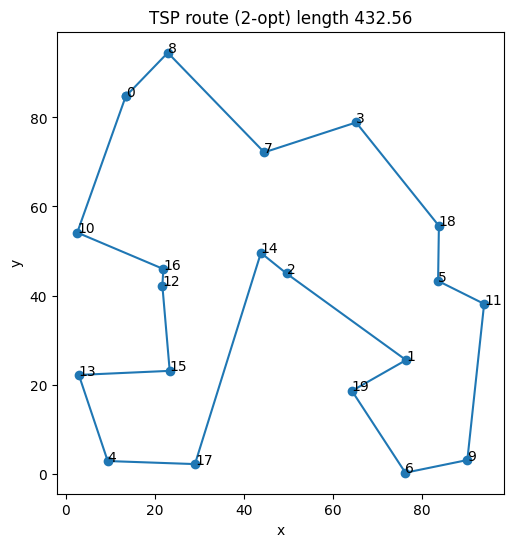

In [49]:
# Demo: generate points, solve, and plot
import random
random.seed(1)

n = 20                            ################### Edit num. points here ##############  # change to <=10 for exact solve; increase for larger tests

to_points = [(random.random()*100, random.random()*100) for _ in range(n)]

to_route, total_len, D, method = tsp_solve(to_points)
print(f"Method: {method}, total length: {total_len:.2f}")
print("Route:", to_route)
plot_route(to_points, to_route, title=f"TSP route ({method}) length {total_len:.2f}")

[0, 8, 7, 3, 18, 5, 11, 1, 9, 6, 19, 2, 14, 16, 12, 15, 17, 4, 13, 10]


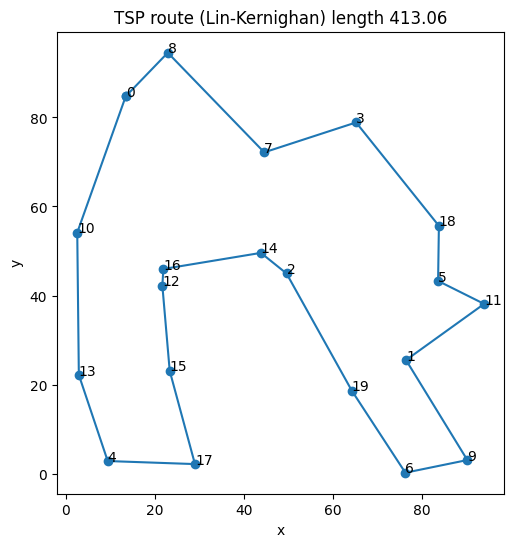

In [50]:
from python_tsp.heuristics import solve_tsp_lin_kernighan


# Demo: generate points, solve, and plot
import random
random.seed(1)

lk_n = 20                          ################### Edit num. points here ##############  # LKH takes a bit longer after 15 for random, 26 for same seed

lk_points = [(random.random()*100, random.random()*100) for _ in range(lk_n)]

lk_D = euclidean_matrix(lk_points)
lk_route, lk_distance = solve_tsp_lin_kernighan(lk_D)

    
print(lk_route)
plot_route(lk_points, lk_route, title=f"TSP route (Lin-Kernighan) length {lk_distance:.2f}")

In [51]:
import matplotlib.pyplot as plt

def calculate_total_tour_time(points, truck_route, drone_operations, truck_speed=1.0, drone_speed=1.25):         ############## Edit speeds here ############
    """
    Calculate the total tour time including truck travel and drone operations.
    
    Args:
        points (list of tuples): Coordinates of all points.
        truck_route (list of int): Truck route with drone customers already removed.
        drone_operations (list of tuples): [(launch_idx, drone_customer_idx, retrieval_idx), ...]
        truck_speed (float): Speed of the truck.
        drone_speed (float): Speed of the drone.
    
    Returns:
        float: Total tour time.
    """
    D = euclidean_matrix(points)

    # Calculate base truck time
    truck_time = 0.0
    for i in range(len(truck_route)):
        start = truck_route[i]
        end = truck_route[(i + 1) % len(truck_route)]
        truck_time += D[start][end] / truck_speed

    # Add drone wait times if drone takes longer
    for delivery in drone_operations:
        launch, customer, retrieval = delivery
        drone_time = (D[launch][customer] + D[customer][retrieval]) / drone_speed
        truck_pass_time = D[launch][retrieval] / truck_speed
        if drone_time > truck_pass_time:
            truck_time += drone_time - truck_pass_time
            print(f"Truck waits {drone_time - truck_pass_time:.2f} time for drone to return from customer {customer}")

    return truck_time


def plot_routes_with_drones(points, truck_route, drone_operations):
    """
    Plots the truck and drone routes on a 2D map.
    
    Args:
        points (list of tuples): Coordinates of the points [(x1, y1), (x2, y2), ...].
        truck_route (list of int): Indices of points in the original truck route (including depot).
        drone_operations (list of tuples): [(launch_idx, drone_customer_idx, retrieval_idx), ...]
        truck_speed (float): Speed of the truck.
        drone_speed (float): Speed of the drone.
    """
    # Extract drone customers for removal from truck route
    drone_customers = [op[1] for op in drone_operations]
    
    # Remove drone delivery points from the truck route
    updated_truck_route = [p for p in truck_route if p not in drone_customers]
    
    # Ensure the truck route is cyclic (connects last node back to the first)
    if updated_truck_route[-1] != updated_truck_route[0]:
        updated_truck_route.append(updated_truck_route[0])
    
    # Calculate total tour time
    total_tour_time = calculate_total_tour_time(points, updated_truck_route, drone_operations)
    print(f"\nTotal tour time with drones: {total_tour_time:.2f} time units")
    
    # Plot all points
    x, y = zip(*points)
    plt.scatter(x, y, c='blue', label='Delivery Points', s=100, zorder=3)
    
    # Highlight depot
    plt.scatter([points[0][0]], [points[0][1]], c='red', marker='s', 
                s=150, label='Depot', zorder=4)
    
    # Annotate points with their indices
    for i, (px, py) in enumerate(points):
        plt.text(px + 1, py + 1, str(i), fontsize=9, ha='left')
    
    # Plot truck route
    for i in range(len(updated_truck_route) - 1):
        start, end = updated_truck_route[i], updated_truck_route[i + 1]
        plt.plot([points[start][0], points[end][0]], 
                 [points[start][1], points[end][1]], 
                 'g-', linewidth=2, label='Truck Route' if i == 0 else "", zorder=1)
    
    # Plot drone arcs
    drone_label_added = False
    for launch, drone_cust, retrieval in drone_operations:
        # Launch arc (from truck to customer)
        plt.plot([points[launch][0], points[drone_cust][0]], 
                 [points[launch][1], points[drone_cust][1]], 
                 'r--', linewidth=2, label='Drone Arc' if not drone_label_added else "", zorder=2)
        # Retrieval arc (from customer back to truck)
        plt.plot([points[drone_cust][0], points[retrieval][0]], 
                 [points[drone_cust][1], points[retrieval][1]], 
                 'r--', linewidth=2, zorder=2)
        drone_label_added = True
        
        # Mark drone delivery points distinctly
        plt.scatter([points[drone_cust][0]], [points[drone_cust][1]], 
                   c='orange', marker='^', s=120, zorder=3)
    
    # Add legend and labels
    plt.legend(loc='best')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Truck and Drone Delivery Routes, Tour Time: {total_tour_time:.2f}')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [52]:
def calculate_drone_operations(points, truck_route, drone_range=50.0, truck_speed=1.0, drone_speed=1.25, verbose=True):
    """
    Calculate optimal drone delivery operations for a given truck route.
    
    Args:
        points (list of tuples): Coordinates of all points [(x, y), ...].
        truck_route (list of int): Indices of points in the truck route.
        drone_range (float): Maximum distance a drone can fly (launch + delivery + retrieval).
        truck_speed (float): Speed of the truck.
        drone_speed (float): Speed of the drone.
        verbose (bool): Whether to print detailed information.
    
    Returns:
        list of tuples: Drone operations as [(launch_idx, customer_idx, retrieval_idx), ...]
    """
    # Calculate distance matrix
    D = euclidean_matrix(points)
    
    if verbose:
        print("=" * 60)
        print("TRUCK ROUTE SEGMENTS:")
        print("=" * 60)
        for i in range(len(truck_route)):
            segment_dist = D[truck_route[i]][truck_route[(i+1)%len(truck_route)]]
            print(f"Segment {truck_route[i]} -> {truck_route[(i+1)%len(truck_route)]}: {segment_dist:.2f}")
        print()
    
    # Calculate savings for each potential drone delivery
    skip_savings = []
    drone_distances = []
    
    for skip_idx in range(len(truck_route)):
        # Calculate savings if this customer is served by drone instead of truck
        prev_customer = truck_route[skip_idx - 1]
        current_customer = truck_route[skip_idx]
        next_customer = truck_route[(skip_idx + 1) % len(truck_route)]
        
        # Truck distance with current customer
        truck_dist_with = (D[prev_customer][current_customer] + 
                          D[current_customer][next_customer])
        
        # Truck distance skipping current customer
        truck_dist_without = D[prev_customer][next_customer]
        
        # Savings (positive means truck saves distance)
        savings = truck_dist_with - truck_dist_without
        
        # Total drone flight distance needed
        drone_dist = (D[prev_customer][current_customer] + 
                     D[current_customer][next_customer])
        
        skip_savings.append((savings, current_customer))
        drone_distances.append(drone_dist)
        
        if verbose:
            print(f"Customer {current_customer}: savings = {savings:.2f}, drone distance = {drone_dist:.2f}")
    
    # Filter by drone range and sort by savings (best first)
    best_drone_deliveries = sorted(
        (skip_savings[i] for i in range(len(truck_route)) 
         if drone_distances[i] <= drone_range),
        reverse=True
    )
    
    if verbose:
        print(f"\n{'=' * 60}")
        print(f"FEASIBLE DRONE DELIVERIES (within range {drone_range:.2f}):")
        print(f"{'=' * 60}")
        for savings, customer in best_drone_deliveries:
            print(f"  Customer {customer}: savings = {savings:.2f}")
    
    # Extract drone customer points
    drone_points = [delivery[1] for delivery in best_drone_deliveries]
    
    # Remove depot if it's in the list (depot should always be visited by truck)
    if 0 in drone_points:
        drone_points.remove(0)
    
    # Ensure no two drone points are adjacent in the truck route
    # (truck needs to travel between launch and retrieval points)
    filtered_drone_points = []
    for point in drone_points:
        # Check if current point is adjacent to any already selected drone point
        is_adjacent = any(
            abs(truck_route.index(point) - truck_route.index(filtered_point)) == 1
            for filtered_point in filtered_drone_points
        )
        # Only add if not adjacent to existing drone deliveries
        if not is_adjacent:
            filtered_drone_points.append(point)
    
    drone_points = filtered_drone_points
    
    # Create drone operations as (launch, customer, retrieval) tuples
    drone_operations = []
    for drone_point in drone_points:
        idx = truck_route.index(drone_point)
        launch = truck_route[idx - 1]  # previous point in route
        retrieval = truck_route[(idx + 1) % len(truck_route)]  # next point (wraps to depot)
        drone_operations.append((launch, drone_point, retrieval))
    
    if verbose:
        print(f"\n{'=' * 60}")
        print(f"SELECTED DRONE OPERATIONS:")
        print(f"{'=' * 60}")
        for op in drone_operations:
            print(f"  Launch from {op[0]}, deliver to {op[1]}, retrieve at {op[2]}")
        print()
    
    return drone_operations


def compare_routes(points, routes_dict, drone_range=50.0, truck_speed=1.0, drone_speed=1.25):
    """
    Compare multiple routing solutions with drone integration.
    
    Args:
        points (list of tuples): Coordinates of all points.
        routes_dict (dict): Dictionary of route name -> route list.
                           e.g., {'Nearest Neighbor': [0,1,2,...], 'LK-Heuristic': [0,3,1,...]}
        drone_range (float): Maximum drone flight distance.
        truck_speed (float): Speed of the truck.
        drone_speed (float): Speed of the drone.
    
    Returns:
        dict: Results for each route with keys 'truck_only_time', 'with_drones_time', 
              'drone_operations', 'improvement_pct'
    """
    D = euclidean_matrix(points)
    results = {}
    
    print("\n" + "=" * 80)
    print("ROUTE COMPARISON")
    print("=" * 80)
    
    for route_name, truck_route in routes_dict.items():
        print(f"\n{'*' * 80}")
        print(f"ANALYZING: {route_name}")
        print(f"{'*' * 80}")
        
        # Calculate truck-only time
        truck_only_time = 0.0
        for i in range(len(truck_route)):
            start = truck_route[i]
            end = truck_route[(i + 1) % len(truck_route)]
            truck_only_time += D[start][end] / truck_speed
        
        # Get drone operations
        drone_operations = calculate_drone_operations(
            points, truck_route, drone_range, truck_speed, drone_speed, verbose=True
        )
        
        # Calculate time with drones
        drone_customers = [op[1] for op in drone_operations]
        updated_truck_route = [p for p in truck_route if p not in drone_customers]
        
        with_drones_time = calculate_total_tour_time(
            points, updated_truck_route, drone_operations, truck_speed, drone_speed
        )
        
        improvement_pct = ((truck_only_time - with_drones_time) / truck_only_time) * 100
        
        results[route_name] = {
            'truck_only_time': truck_only_time,
            'with_drones_time': with_drones_time,
            'drone_operations': drone_operations,
            'improvement_pct': improvement_pct,
            'num_drone_deliveries': len(drone_operations)
        }
        
        print(f"\nRESULTS for {route_name}:")
        print(f"  Truck-only time: {truck_only_time:.2f}")
        print(f"  With drones time: {with_drones_time:.2f}")
        print(f"  Improvement: {improvement_pct:.2f}%")
        print(f"  Number of drone deliveries: {len(drone_operations)}")
    
    # Summary comparison
    print(f"\n{'=' * 80}")
    print("SUMMARY COMPARISON")
    print(f"{'=' * 80}")
    print(f"{'Method':<25} {'Truck Only':<15} {'With Drones':<15} {'Improvement':<15} {'# Drones'}")
    print("-" * 80)
    for route_name, result in results.items():
        print(f"{route_name:<25} {result['truck_only_time']:>12.2f}   "
              f"{result['with_drones_time']:>12.2f}   "
              f"{result['improvement_pct']:>11.2f}%   "
              f"{result['num_drone_deliveries']:>7}")
    
    return results

TRUCK ROUTE SEGMENTS:
Segment 0 -> 8: 13.60
Segment 8 -> 7: 31.14
Segment 7 -> 3: 21.69
Segment 3 -> 18: 29.76
Segment 18 -> 5: 12.37
Segment 5 -> 11: 11.55
Segment 11 -> 9: 35.26
Segment 9 -> 6: 14.20
Segment 6 -> 19: 21.95
Segment 19 -> 1: 13.98
Segment 1 -> 2: 33.14
Segment 2 -> 14: 7.39
Segment 14 -> 17: 49.69
Segment 17 -> 4: 19.60
Segment 4 -> 13: 20.39
Segment 13 -> 15: 20.42
Segment 15 -> 12: 19.20
Segment 12 -> 16: 3.76
Segment 16 -> 10: 20.99
Segment 10 -> 0: 32.48

Customer 0: savings = 0.86, drone distance = 46.08
Customer 8: savings = 11.18, drone distance = 44.74
Customer 7: savings = 7.74, drone distance = 52.83
Customer 3: savings = 8.89, drone distance = 51.44
Customer 18: savings = 2.05, drone distance = 42.13
Customer 5: savings = 3.67, drone distance = 23.92
Customer 11: savings = 6.07, drone distance = 46.82
Customer 9: savings = 7.63, drone distance = 49.47
Customer 6: savings = 5.94, drone distance = 36.15
Customer 19: savings = 10.63, drone distance = 35.93
Cust

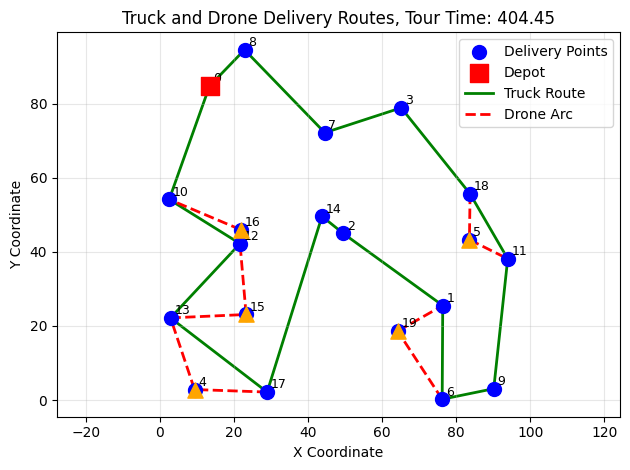

In [53]:
to_drone_ops = calculate_drone_operations(to_points, to_route, drone_range=40.0, verbose=True)
plot_routes_with_drones(to_points, to_route, to_drone_ops)

TRUCK ROUTE SEGMENTS:
Segment 0 -> 8: 13.60
Segment 8 -> 7: 31.14
Segment 7 -> 3: 21.69
Segment 3 -> 18: 29.76
Segment 18 -> 5: 12.37
Segment 5 -> 11: 11.55
Segment 11 -> 1: 21.60
Segment 1 -> 9: 26.33
Segment 9 -> 6: 14.20
Segment 6 -> 19: 21.95
Segment 19 -> 2: 30.17
Segment 2 -> 14: 7.39
Segment 14 -> 16: 22.21
Segment 16 -> 12: 3.76
Segment 12 -> 15: 19.20
Segment 15 -> 17: 21.69
Segment 17 -> 4: 19.60
Segment 4 -> 13: 20.39
Segment 13 -> 10: 31.97
Segment 10 -> 0: 32.48

Customer 0: savings = 0.86, drone distance = 46.08
Customer 8: savings = 11.18, drone distance = 44.74
Customer 7: savings = 7.74, drone distance = 52.83
Customer 3: savings = 8.89, drone distance = 51.44
Customer 18: savings = 2.05, drone distance = 42.13
Customer 5: savings = 3.67, drone distance = 23.92
Customer 11: savings = 13.98, drone distance = 33.16
Customer 1: savings = 12.67, drone distance = 47.93
Customer 9: savings = 15.24, drone distance = 40.54
Customer 6: savings = 5.94, drone distance = 36.15
Cus

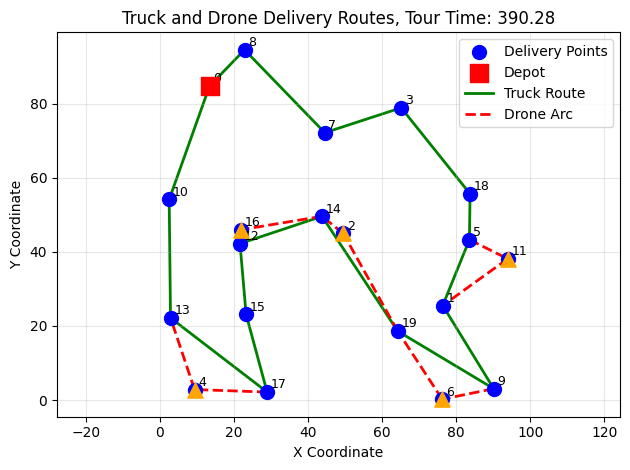

In [54]:
lk_drone_ops = calculate_drone_operations(lk_points, lk_route, drone_range=40.0, verbose=True)
plot_routes_with_drones(lk_points, lk_route, lk_drone_ops)

# Next step if possible: Drone not need to return to next sequential, try two in advance

# Full model attempt (20 point comparison)

Generated 20 points (1 depot + 19 customers)

Building distance-based MILP: 20 nodes, 2 drones
Drone range: 40.00
Adding constraints...
Model built. Variables: 27132, Constraints: 56115

Solving with Gurobi (time limit: 120s)...

Solution Status: Optimal
Objective Value (Total Time - Approx): 388.03
Truck route (linear): [0, 10, 13, 17, 15, 12, 2, 19, 9, 1, 5, 18, 3, 7, 8]
Truck route length: 15 nodes
  Drone 1 delivery to 11: truck waits 7.35

Truck visits 14 customers
Drones deliver to 5 customers
  Drone 0: 2 deliveries
  Drone 1: 3 deliveries
Total time (with speeds): 388.03

SOLUTION SUMMARY
Truck Route: [0, 10, 13, 17, 15, 12, 2, 19, 9, 1, 5, 18, 3, 7, 8]

Drone Operations (launch, customer, retrieval, drone_id):
  Drone 1: Launch from 13, deliver to 4, retrieve at 17
  Drone 0: Launch from 19, deliver to 6, retrieve at 9
  Drone 1: Launch from 1, deliver to 11, retrieve at 5
  Drone 0: Launch from 12, deliver to 14, retrieve at 2
  Drone 1: Launch from 12, deliver to 16, retriev

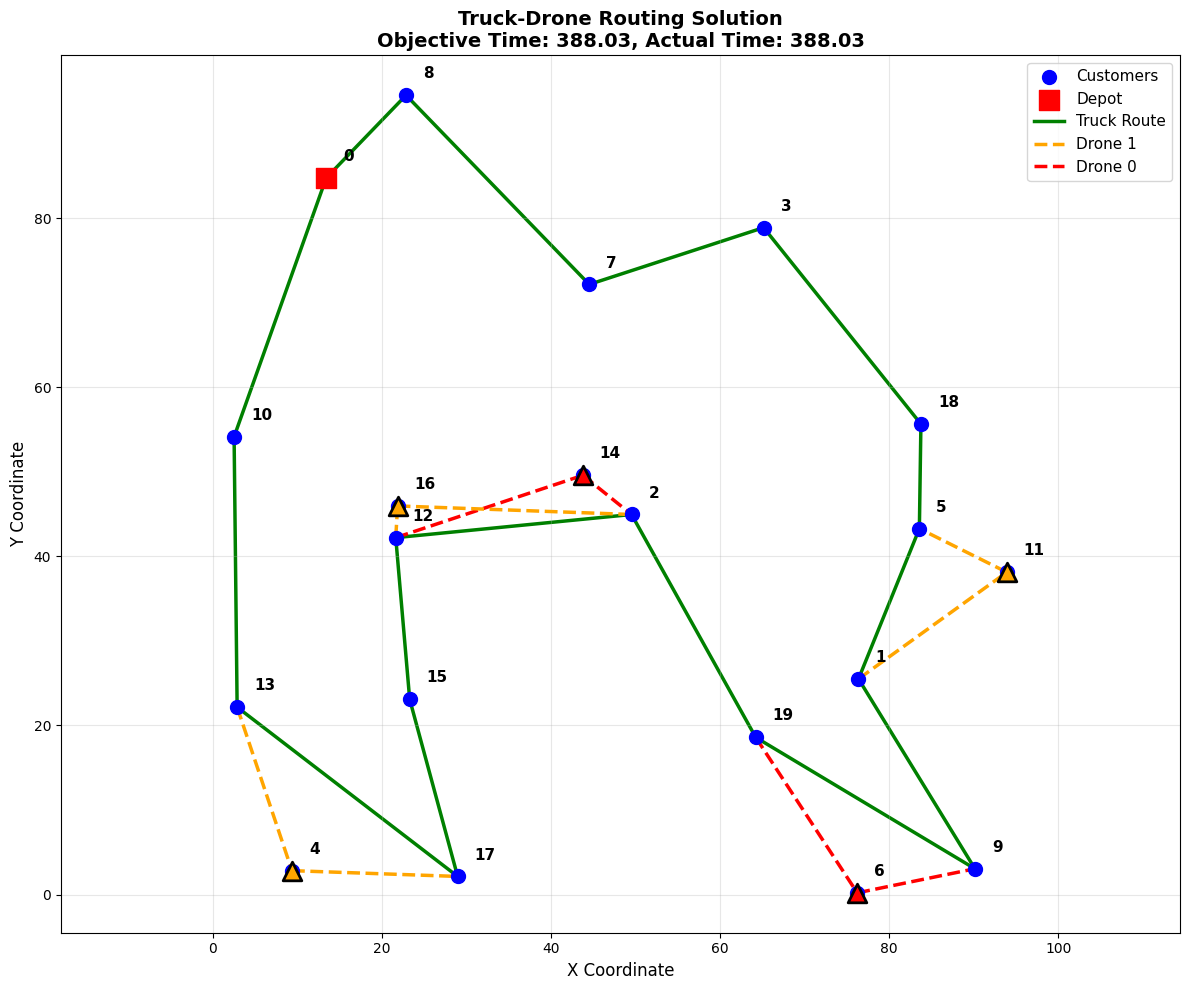

In [55]:
import numpy as np
from pulp import *
from pulp import GUROBI_CMD
import matplotlib.pyplot as plt
import random

def euclidean_matrix(points):
    """Compute Euclidean distance matrix."""
    n = len(points)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.sqrt((points[i][0] - points[j][0])**2 + 
                          (points[i][1] - points[j][1])**2)
            D[i][j] = D[j][i] = dist
    return D

def manhattan_matrix(points):
    """Compute Manhattan distance matrix."""
    n = len(points)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = abs(points[i][0] - points[j][0]) + abs(points[i][1] - points[j][1])
            D[i][j] = D[j][i] = dist
    return D

def solve_tdrp_distance_based(points, distance_type, num_drones, drone_range, 
                              truck_speed, drone_speed, time_limit=180):
    """
    Simplified distance-based MILP for Truck-Drone Routing Problem.
    
    Minimizes total time (distance/speed), then calculates detailed time afterwards.
    Much simpler and more likely to solve quickly.
    
    Args:
        points: List of (x, y) coordinates, with points[0] as depot
        num_drones: Number of available drones
        drone_range: Maximum distance a drone can fly (out + back)
        truck_speed: Speed of truck
        drone_speed: Speed of drone
        time_limit: Maximum solving time in seconds
    
    Returns:
        Dictionary with solution details
    """
    
    n = len(points)
    if distance_type == 'euclidean':
        D = euclidean_matrix(points)    
    elif distance_type == 'manhattan':
        D = manhattan_matrix(points)
    else:
        raise ValueError("Invalid distance_type. Choose 'euclidean' or 'manhattan'.")
    
    # Sets
    depot = 0
    C = list(range(1, n))  # Customers only
    N = list(range(n))     # All nodes
    
    # Big M
    M = 1000
    
    print(f"Building distance-based MILP: {n} nodes, {num_drones} drones")
    print(f"Drone range: {drone_range:.2f}")
    
    model = LpProblem("TDRP_Distance", LpMinimize)
    
    # === DECISION VARIABLES ===
    
    # x[i,j]: truck travels from i to j
    x = LpVariable.dicts("x", ((i, j) for i in N for j in N if i != j), cat='Binary')
    
    # served_by_truck[i]: customer i is served by truck (not drone)
    served_by_truck = LpVariable.dicts("truck", C, cat='Binary')
    
    # drone_delivers[i,j,k]: drone k delivers to customer i from truck location j and returns to next truck location
    drone_delivers = LpVariable.dicts("drone", 
                                     ((i, j, k) for i in C for j in N for k in range(num_drones) if i != j), 
                                     cat='Binary')
    
    # === OBJECTIVE: Minimize total time with better drone accounting ===
    # 
    # Key insight: A drone delivery from j to i to next_j takes time max(truck_time, drone_time)
    # We need to linearize the product of binary variables using auxiliary variables
    
    # Base truck time for all segments
    truck_time_obj = lpSum(D[i][j] / truck_speed * x[i, j] for i in N for j in N if i != j)
    
    # Auxiliary binary variable: y_and_x[i,j,k,next_j] = drone_delivers[i,j,k] AND x[j,next_j]
    y_and_x = LpVariable.dicts("y_and_x",
                               ((i,j,k,next_j) for i in C for j in N if i != j
                                for k in range(num_drones)
                                for next_j in N if next_j != i and next_j != j),
                               cat='Binary')
    
    # Linearization constraints: y_and_x = drone_delivers AND x
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    for next_j in N:
                        if next_j != i and next_j != j:
                            # y_and_x <= drone_delivers
                            model += (y_and_x[i,j,k,next_j] <= drone_delivers.get((i,j,k), 0),
                                     f"Lin1_{i}_{j}_{k}_{next_j}")
                            # y_and_x <= x
                            model += (y_and_x[i,j,k,next_j] <= x.get((j,next_j), 0),
                                     f"Lin2_{i}_{j}_{k}_{next_j}")
                            # y_and_x >= drone_delivers + x - 1
                            model += (y_and_x[i,j,k,next_j] >= 
                                     drone_delivers.get((i,j,k), 0) + x.get((j,next_j), 0) - 1,
                                     f"Lin3_{i}_{j}_{k}_{next_j}")
    
    # Drone waiting time penalty using linearized variable
    drone_penalty = LpVariable.dicts("drone_wait", 
                                     ((i,j,k,next_j) for i in C for j in N if i != j 
                                      for k in range(num_drones)
                                      for next_j in N if next_j != i and next_j != j),
                                     lowBound=0)
    
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    for next_j in N:
                        if next_j != i and next_j != j:
                            # Calculate waiting time
                            drone_time = D[j][i] / drone_speed + D[i][next_j] / drone_speed
                            truck_segment_time = D[j][next_j] / truck_speed
                            waiting = drone_time - truck_segment_time
                            
                            # Only add waiting time when both conditions are true (using linearized variable)
                            model += (drone_penalty[i,j,k,next_j] >= waiting * y_and_x[i,j,k,next_j],
                                     f"Wait_{i}_{j}_{k}_{next_j}")
    
    # Total objective: truck time + waiting time for slow drones
    model += truck_time_obj + lpSum(drone_penalty.values()), "Total_Time"
    
    print("Adding constraints...")
    
    # === CONSTRAINTS ===
    
    # C1: Each customer served exactly once (truck OR drone)
    for i in C:
        model += (served_by_truck[i] + 
                  lpSum(drone_delivers[i, j, k] for j in N if j != i for k in range(num_drones)) == 1,
                  f"Serve_{i}")
    
    
    # C2: If customer served by truck, truck must visit it
    for i in C:
        model += (lpSum(x[j, i] for j in N if j != i) == served_by_truck[i],
                  f"Truck_visit_{i}")
    
    # C3: Truck flow conservation
    model += lpSum(x[depot, j] for j in C) == 1, "Leave_depot"
    model += lpSum(x[i, depot] for i in C) == 1, "Return_depot"
    
    for j in C:
        model += (lpSum(x[i, j] for i in N if i != j) == 
                  lpSum(x[j, i] for i in N if i != j),
                  f"Flow_{j}")
    
    # C4: Subtour elimination (MTZ) - only for customers visited by truck
    u = LpVariable.dicts("u", C, lowBound=0, upBound=n)
    for i in C:
        for j in C:
            if i != j:
                model += (u[i] - u[j] + n * x[i, j] <= n - 1 + M * (1 - served_by_truck[i]) + M * (1 - served_by_truck[j]),
                         f"MTZ_{i}_{j}")
    
    # C5: Drone range constraint - simplified version
    # Drone can only deliver if total distance (launch to customer to retrieval) <= range
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    # Minimum possible drone trip from any location
                    min_drone_dist = min(D[j][i] + D[i][m] for m in N if m != i)                                        ############## This should be min!!! ##############
                    if min_drone_dist > drone_range:
                        # If even the best case violates range, forbid this delivery
                        model += drone_delivers[i, j, k] == 0, f"Range_forbid_{i}_{j}_{k}"
                    else:
                        # Add constraint that checks against actual next location
                        for next_j in N:
                            if next_j != i and next_j != j:
                                model += (D[j][i] + D[i][next_j] <= 
                                        drone_range + M * (1 - drone_delivers[i, j, k]) + M * (1 - x[j, next_j]),
                                        f"Range_{i}_{j}_{k}_{next_j}")
    
    # C6: Drone can only launch from truck location (including depot)
    for i in C:
        for j in C:  # Only from customer locations (truck must visit)
            if i != j:
                for k in range(num_drones):
                    model += drone_delivers[i, j, k] <= served_by_truck[j], f"Launch_{i}_{j}_{k}"
    
    # Drones can also launch from depot (depot is always visited)
    # No additional constraint needed for depot launches
    
    # C7: Each drone can make multiple deliveries (removed single-use constraint)
    # Instead, ensure no consecutive deliveries without truck rendezvous
    # A drone can deliver to customer i1 from truck location j1, then later deliver to i2 from j2
    # as long as j1 and j2 are different (truck has moved between deliveries)
    
    # For each pair of consecutive truck stops, same drone can only do one delivery
    for k in range(num_drones):
        for j in N:
            for next_j in N:
                if j != next_j:
                    # Between truck locations j and next_j, drone k can deliver at most once
                    # Only apply constraint if x[j, next_j] == 1
                    model += (lpSum(drone_delivers.get((i, j, k), 0) for i in C if i != j and i != next_j) 
                             <= 1 + M * (1 - x.get((j, next_j), 0)),
                             f"Drone_sequential_{k}_{j}_{next_j}")
    
    # C8: Depot cannot be a drone delivery destination
    # (Drones can launch FROM and return TO depot, but depot is not a customer)
    # This is implicitly satisfied since depot is not in C (customer set)
    
    print(f"Model built. Variables: {model.numVariables()}, Constraints: {model.numConstraints()}")
    
    # Debug: print constraint summary
    #print(f"  C1 (serve each customer): {len(C)} constraints")
    #print(f"  C2 (truck visit if served): {len(C)} constraints")
    #print(f"  C7 (sequential drone limit): ~{len(N) * len(N) * num_drones} constraints")
    
    # Solve
    print(f"\nSolving with Gurobi (time limit: {time_limit}s)...")
    
    solver = GUROBI_CMD(
        timeLimit=time_limit,
        msg=1,
        options=[
            ("MIPGap", 0.10),
            ("MIPFocus", 1),
            ("Heuristics", 0.5)
        ]
    )
    
    model.solve(solver)
    
    status = LpStatus[model.status]
    print(f"\nSolution Status: {status}")
    
    if status not in ['Optimal', 'Feasible']:
        print("\n*** No solution found ***")
        return None
    
    obj_value = value(model.objective)
    print(f"Objective Value (Total Time - Approx): {obj_value:.2f}")
    

    
    # Extract truck route (need to extract as a cycle to handle wrap-around)
    truck_route = [depot]
    current = depot
    visited = {depot}
    
    # Build the route following the edges
    for _ in range(n):
        for j in N:
            if j not in visited and value(x.get((current, j), 0)) > 0.5:
                truck_route.append(j)
                visited.add(j)
                current = j
                break
        else:
            break
    
    # Create a mapping of truck route order for wrap-around checks
    truck_route_map = {node: idx for idx, node in enumerate(truck_route)}
    
    print(f"Truck route (linear): {truck_route}")
    print(f"Truck route length: {len(truck_route)} nodes")
    
    # Verify all customers are served
    drone_customers = set()
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    if value(drone_delivers.get((i, j, k), 0)) > 0.5:
                        drone_customers.add(i)
    
    
    # Extract drone operations
    drone_ops = []
    for i in C:
        for j in N:
            if i != j:
                for k in range(num_drones):
                    if value(drone_delivers.get((i, j, k), 0)) > 0.5:
                        # Find retrieval point
                        retrieval = None
                        for next_j in N:
                            if next_j != i and next_j != j and value(x.get((j, next_j), 0)) > 0.5:
                                retrieval = next_j
                                break
                        if retrieval is not None:
                            drone_ops.append((j, i, retrieval, k))
    

    
    total_time = calculate_tour_time_milp(points, truck_route, drone_ops, truck_speed, drone_speed)
    
    print(f"\nTruck visits {len([i for i in truck_route if i != depot])} customers")
    print(f"Drones deliver to {len(drone_ops)} customers")
    
    # Count deliveries per drone
    drone_delivery_count = {}
    for op in drone_ops:
        drone_id = op[3]
        drone_delivery_count[drone_id] = drone_delivery_count.get(drone_id, 0) + 1
    
    for drone_id, count in sorted(drone_delivery_count.items()):
        print(f"  Drone {drone_id}: {count} deliveries")
    
    print(f"Total time (with speeds): {total_time:.2f}")
    
    return {
        'status': status,
        'objective_time': obj_value,
        'total_time': total_time,
        'truck_route': truck_route,
        'drone_operations': drone_ops,
        'model': model
    }

def calculate_tour_time_milp(points, truck_route, drone_ops, truck_speed, drone_speed):
    """Calculate actual tour time considering truck and drone speeds."""
    D = euclidean_matrix(points)
    
    # Get drone customers
    drone_customers = [op[1] for op in drone_ops]
    
    # Remove drone customers from truck route
    truck_route_actual = [node for node in truck_route if node not in drone_customers]
    
    # Calculate truck time
    truck_time = 0.0
    for i in range(len(truck_route_actual)):
        start = truck_route_actual[i]
        end = truck_route_actual[(i + 1) % len(truck_route_actual)]
        truck_time += D[start][end] / truck_speed
    
    # Add waiting time for drones
    for launch, customer, retrieval, drone_id in drone_ops:
        drone_flight_time = (D[launch][customer] + D[customer][retrieval]) / drone_speed
        truck_segment_time = D[launch][retrieval] / truck_speed
        
        if drone_flight_time > truck_segment_time:
            wait_time = drone_flight_time - truck_segment_time
            truck_time += wait_time
            print(f"  Drone {drone_id} delivery to {customer}: truck waits {wait_time:.2f}")
    
    return truck_time

def visualize_stdrp_solution(points, distance_type, solution):
    """Visualize the STDRP solution."""
    if solution is None:
        print("No solution to visualize.")
        return
    
    truck_route = solution['truck_route']
    drone_ops = solution['drone_operations']
    
    plt.figure(figsize=(12, 10))
    
    # Plot all points
    x, y = zip(*points)
    plt.scatter(x, y, c='blue', s=100, zorder=3, label='Customers')
    
    # Highlight depot
    plt.scatter([points[0][0]], [points[0][1]], c='red', marker='s', 
                s=200, label='Depot', zorder=4)
    
    # Annotate points
    for i, (px, py) in enumerate(points):
        plt.text(px + 2, py + 2, str(i), fontsize=11, ha='left', fontweight='bold')
    
    if distance_type == 'euclidean':
        # Plot truck route
        for i in range(len(truck_route)):
            start = truck_route[i]
            end = truck_route[(i + 1) % len(truck_route)]
            plt.plot([points[start][0], points[end][0]], 
                    [points[start][1], points[end][1]], 
                    'g-', linewidth=2.5, label='Truck Route' if i == 0 else "", zorder=1)
    elif distance_type == 'manhattan':
        # Plot truck route with Manhattan (L1) paths
        for i in range(len(truck_route)):
            start = truck_route[i]
            end = truck_route[(i + 1) % len(truck_route)]

            x1, y1 = points[start]
            x2, y2 = points[end]

            # First horizontal, then vertical (Manhattan path)
            # Horizontal segment
            plt.plot([x1, x2], [y1, y1],
                    'g-', linewidth=2.5,
                    label='Truck Route' if i == 0 else "",
                    zorder=1)

            # Vertical segment
            plt.plot([x2, x2], [y1, y2],
                    'g-', linewidth=2.5,
                    zorder=1)
    else:
        raise ValueError("Invalid distance_type. Choose 'euclidean' or 'manhattan'.")


    # Plot drone operations
    colors = ['red', 'orange', 'purple', 'brown', 'pink']
    drone_labels_added = set()
    
    for (launch, customer, retrieval, drone_id) in drone_ops:
        color = colors[drone_id % len(colors)]
        
        # Launch arc
        plt.plot([points[launch][0], points[customer][0]], 
                 [points[launch][1], points[customer][1]], 
                 '--', color=color, linewidth=2.5, 
                 label=f'Drone {drone_id}' if drone_id not in drone_labels_added else "", 
                 zorder=2)
        
        # Retrieval arc
        plt.plot([points[customer][0], points[retrieval][0]], 
                 [points[customer][1], points[retrieval][1]], 
                 '--', color=color, linewidth=2.5, zorder=2)
        
        drone_labels_added.add(drone_id)
        
        # Mark drone delivery
        plt.scatter([points[customer][0]], [points[customer][1]], 
                   c=color, marker='^', s=180, zorder=5, edgecolors='black', linewidths=2)
    
    plt.legend(loc='best', fontsize=11)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.title(f"Truck-Drone Routing Solution\nObjective Time: {solution['objective_time']:.2f}, Actual Time: {solution['total_time']:.2f}", 
             fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate small instance
    random.seed(1)
    n = 20  
    #points = [(50, 50)]  # Depot at center
    points = [(random.random()*100, random.random()*100) for _ in range(n)]
    distance_type = 'euclidean'                                                         ########### Change distance type here #############
    
    print(f"Generated {n} points (1 depot + {n-1} customers)\n")
    
    # Solve with distance-based model
    solution = solve_tdrp_distance_based(
        points,
        distance_type,
        num_drones=2,
        drone_range=40.0,    # Max distance for drone round trip
        truck_speed=1.0,
        drone_speed=1.25,
        time_limit=120
    )
    
    if solution:
        print("\n" + "="*70)
        print("SOLUTION SUMMARY")
        print("="*70)
        print(f"Truck Route: {solution['truck_route']}")
        print(f"\nDrone Operations (launch, customer, retrieval, drone_id):")
        for op in solution['drone_operations']:
            print(f"  Drone {op[3]}: Launch from {op[0]}, deliver to {op[1]}, retrieve at {op[2]}")
        
        # Visualize
        visualize_stdrp_solution(points, distance_type, solution)